# Pre-Training Using Attention based UNet

In [2]:
import torch
import torch.nn as nn
from torch.nn import init

def single_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,2),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,2),stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,3),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,3), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv


def up_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=(2, 2), stride=2))
    return conv
    
def up_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=(2,2), stride=2))
    return conv


class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi



class Att_R2U(nn.Module):
    def __init__(self,img_ch=3,output_ch=3,t=2):
        super(Att_R2U, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.RCNN1 = RRCNN_block(img_ch, 64, t=t)
        self.RCNN2 = RRCNN_block(64, 128, t=t)
        self.RCNN3 = RRCNN_block(128, 256, t=t)

        self.up_trans_1 = up_conv1(256, 128)
        self.Att1 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN1 = RRCNN_block(256, 128,t=t)
        
        self.up_trans_2 = up_conv2(128, 64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(128, 64,t=t)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=output_ch,
            kernel_size=1,stride=1,padding=0)

    def forward(self, image):
        # encoder
        # print("Input Image            => ", image.size())
        # print("Encoder =================")
        x1 = self.RCNN1(image)
        # print("Conv3x2, S1, P1        => ", x1.size())
        x2 = self.max_pool_2x2(x1)
        # print("max_pool_2x1           => ", x2.size())
        x3 = self.RCNN2(x2)
        # print("Conv3x3, S1, P1        => ", x3.size())
        x4 = self.max_pool_2x2(x3)
        # print("max_pool_2x1           => ", x4.size())
        x5 = self.RCNN3(x4)
        # print("Conv3x3, S1, P1        => ", x5.size())
        
        
        # decoder
        # print("Decoder =================")
        x = self.up_trans_1(x5)
        # print("up_trans_1x18, S3, P0  => ", x.size())
        x3 = nn.functional.interpolate(x3, (x.size()[2], x.size()[3]))
        x3 = self.Att1(g=x,x=x3)
        x = self.Up_RRCNN1(torch.cat([x, x3], 1))
        # print("up_conv_3x3, S1, P1    => ", x.size())

        x = self.up_trans_2(x)
        # print("up_trans_2x2, S2, P0   => ", x.size())
        x1 = nn.functional.interpolate(x1, (x.size()[2], x.size()[3]))
        x1 = self.Att2(g=x,x=x1)
        x = self.Up_RRCNN2(torch.cat([x, x1], 1))
        # print("up_conv_2x3, s1, p1    => ", x.size())
        # output
        x = self.out(x)
        # print(x.size())
        return x



if __name__ == "__main__":
    print("start")
    image = torch.rand(1, 3, 8, 100)
    model = Att_R2U()
    model(image)

start


# Classifier

In [3]:
import torch
import torch.nn as nn
from torch.nn import init
import logging
from torchvision import models
import numpy as np
import torch.nn.functional as F

def double_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(2,2),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),
        nn.Conv2d(out_c, out_c, kernel_size=(2,2),stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(4,3),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),
        nn.Conv2d(out_c, out_c, kernel_size=(4,3), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv3(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,3),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),
        nn.Conv2d(out_c, out_c, kernel_size=(3,3), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

class encoder(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(encoder, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=(2,1), stride=2)
        self.down_conv_1 = double_conv1(img_ch, 64)
        self.down_conv_2 = double_conv2(64, 128)
        self.down_conv_3 = double_conv3(128, 256)
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(25, 50)
        self.fc2 = nn.Linear(50, 120)
        self.fc3 = nn.Linear(120, 181)
        self.out = nn.Conv2d(
            in_channels=256,
            out_channels=output_ch,
            kernel_size=1,stride=1,padding=0)
    
    def forward(self, image):
    # print("image        => ", image.size())
        x1 = self.down_conv_1(image)
        x1 = self.dropout(x1)
        # print("Conv3x2, S1, P1        => ", x1.size())
        x2 = self.max_pool_2x2(x1)
        # print("max_pool_2x1           => ", x2.size())
        x3 = self.down_conv_2(x2)
        x3 = self.dropout(x3)
        # print("Conv3x3, S1, P1        => ", x3.size())
        x4 = self.max_pool_2x2(x3)
        # print("max_pool_2x1           => ", x4.size())
        x5 = self.down_conv_3(x4)
        x5 = self.dropout(x5)
        # print("Conv3x3, S1, P1        => ", x5.size())
        x6 = self.fc1(x5)
        x6 = self.dropout(x6)
        x7 = self.fc2(x6)
        x7 = self.dropout(x7)
        x8 = self.fc3(x7)
        x8 = self.dropout(x8)
        x = self.out(x8)
        # print("Final                  => ", x.size())
        return x



# model = models.vgg16()

from collections import OrderedDict

if __name__ == "__main__":
    image = torch.rand(1, 3, 8, 100)
    en = encoder()
    en(image)




# Importing dataset and normalization.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen

torch.cuda.empty_cache()

#==========================================================================

df1 = sio.loadmat("./gdrive/MyDrive/DOA/preTrain/SNR_NS_20_50000_1.mat")
#==========================================================================

max_r = 0.2655554840881041
max_i = 0.247665118111416
max_p = 3.141592030578154
min_r = -0.24698739374092077
min_i = -0.23956457294409056
min_p = -3.1415875527493355

class DOA_dataset(Dataset):
    def __init__(self, df):
        transp = np.transpose(df['NS_data'], (2, 0, 1))
        new = np.zeros((50000, 3, 8, 100))
        for i in range(0, transp.shape[0]):
            for j in range(0, transp.shape[1]):
                for k in range(0, transp.shape[2]):
                    new[i][0][j][k] = (transp[i][j][k].real - min_r)/(max_r-min_r)
                    new[i][1][j][k] = (transp[i][j][k].imag - min_i)/(max_i-min_i)
                    new[i][2][j][k] = (cmath.phase(transp[i][j][k]) - min_p)/(max_p-min_p)

        self.x = torch.from_numpy(new)
        self.y = torch.from_numpy(np.asarray(df['DOA']))
        self.n_sample = len(self.y)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_sample


dataset = DOA_dataset(df1)

validation_split = 0.2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(dataset, batch_size=256, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=512,
                                                sampler=valid_sampler)


# Loading Pre-Trained model 

In [8]:
preTrained = Att_R2U()
pre_model = torch.load("./gdrive/MyDrive/DOA/preTrain/SNR_500000.pth")
preTrained.load_state_dict(pre_model, strict=False)

for prams in preTrained.parameters():
  prams.requires_grad = False

en = encoder()
autoencoder = nn.Sequential(preTrained, en)

#==========================================================================

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	autoencoder = autoencoder.cuda()
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	criterion = criterion.cuda()

Tesla T4


# Training Loop

In [10]:
train_loss_list = []
val_loss_list = []
epc_list = []
train_acc_list = []
val_acc_list = []

def train():
  for i in range(200):

    training_loss = 0
    tcorrect = 0
    ttotal = 0
    autoencoder.train()
    for features, labels in train_loader:
      # Label and features assigning
      features, labels = Variable(features.cuda()), Variable(labels.cuda())
      optimizer.zero_grad()
      # Output collection from model
      enn = autoencoder(features.float())
      auto_outputs = torch.transpose(enn, 2, 3)
      auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 1))
      # Loss calculation and updation 
      losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
      losss.backward()
      optimizer.step()
      training_loss += losss.item()
      # Prediction
      _, pred = torch.max(auto_outputs, 1)
      ttotal+= labels.reshape(-1).size(0)
      tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
  
    validation_loss = 0
    correct = 0
    total = 0
    autoencoder.eval()
    with torch.no_grad():
      for features, labels in validation_loader:
        # Label and features assigning
        features, labels = Variable(features.cuda()), Variable(labels.cuda())
        # Output collection from model
        enn = autoencoder(features.float())
        auto_outputs = torch.transpose(enn, 2, 3)
        auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
        # Loss calculation
        loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
        # Prediction
        _, pred = torch.max(auto_outputs, 1)
        total+= labels.reshape(-1).size(0)
        correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
        validation_loss += loss.item()
    train_loss_list.append(training_loss/len(train_loader))
    val_loss_list.append(validation_loss/len(validation_loader))
    epc_list.append(i)
    train_acc_list.append(100*(tcorrect/ttotal))
    val_acc_list.append(100*(correct/total))
    print("Epoch {} - Traningloss: {}".format(i+1, training_loss/len(train_loader)))
    print("Validationloss: {}".format( validation_loss/len(validation_loader)))
    print("Trainig Acc: {}".format( 100*(tcorrect/ttotal)))
    print("Validation Acc: {}".format(100*(correct/total)))

train()
print("Training Complete")

Epoch 1 - Traningloss: 4.986973622355598
Validationloss: 4.646088314056397
Trainig Acc: 0.915
Validation Acc: 0.97
Epoch 2 - Traningloss: 4.485939268106089
Validationloss: 4.603875207901001
Trainig Acc: 1.355
Validation Acc: 1.6099999999999999
Epoch 3 - Traningloss: 4.199946489577857
Validationloss: 4.969483971595764
Trainig Acc: 3.09
Validation Acc: 1.6400000000000001
Epoch 4 - Traningloss: 3.733355043795162
Validationloss: 4.57996495962143
Trainig Acc: 5.5875
Validation Acc: 1.8599999999999999
Epoch 5 - Traningloss: 3.225472515002607
Validationloss: 4.229899072647095
Trainig Acc: 9.977500000000001
Validation Acc: 3.29
Epoch 6 - Traningloss: 2.979253861850824
Validationloss: 3.9005092859268187
Trainig Acc: 11.705
Validation Acc: 5.96
Epoch 7 - Traningloss: 2.8295286189252957
Validationloss: 3.6776549875736237
Trainig Acc: 13.422500000000001
Validation Acc: 6.909999999999999
Epoch 8 - Traningloss: 2.7156532519160748
Validationloss: 3.538292336463928
Trainig Acc: 14.9925
Validation Acc:

# Loss and Accuracy Graph

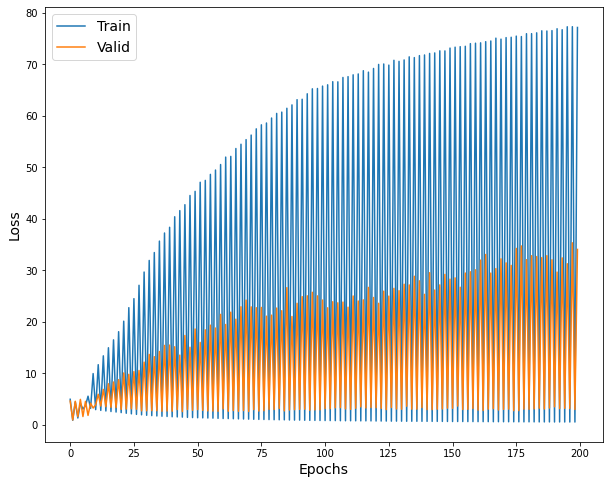

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.plot(epc_list, train_loss_list[:200], label='Train')
plt.plot(epc_list, val_loss_list[:200], label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()



In [ ]:


plt.figure(figsize=(10, 8))
plt.plot(epc_list, train_acc_list, label='Train')
plt.plot(epc_list, val_acc_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

